참고 코드
-  https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution

# 1. Environment Settings

## 1.1. Use GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 1.2. Install Additional Libraries
* Wandb : 그래프 분석

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8MB 9.2MB/s 
     |████████████████████████████████| 143kB 48.2MB/s 
     |████████████████████████████████| 174kB 54.5MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=a3e38370fdae38b85bde1e8ea13482df2012c9eab07323b7e2c9076d07c4143e
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=4ffc23498f92d15938fd57051e637e942bc5c62c172f470949ae153152e21c46
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


## 1.3. Import Libraries

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from pathlib import Path

import keras
from keras import optimizers
from keras.models import Sequential
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

import wandb
from wandb.keras import WandbCallback

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

## 1.4. Load a Dataset
Google Drive에 저장된 데이터세트를 불러옴

### 1.4.1. 로드하기
구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


파일 압축 해제

In [ ]:
!unzip -q "/content/drive/MyDrive/AIAS/dataset/x-ray_3pneumonia.zip" -d dataset
!ls

dataset  drive	sample_data


### 1.4.2. 변수로 저장
파일 경로 정의

In [ ]:
data_dir = Path('/content/dataset/x-ray_3pneumonia') 

train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

이미지 각각 train_data, val_data, test_data에 저장

In [ ]:
labels = ['bacterial_pneumonia', 'viral_pneumonia',  'normal']
img_size = 224

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        os.listdir()
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                resized_arr = np.multiply(resized_arr, 1./255)
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
        print('label[',label,'] finish to get data')
    print()
    return np.array(data)

train_data = get_data(train_dir)
val_data = get_data(val_dir)
test_data = get_data(test_dir)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

label[ bacterial_pneumonia ] finish to get data
label[ viral_pneumonia ] finish to get data
label[ normal ] finish to get data



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


label[ bacterial_pneumonia ] finish to get data
label[ viral_pneumonia ] finish to get data
label[ normal ] finish to get data

label[ bacterial_pneumonia ] finish to get data
label[ viral_pneumonia ] finish to get data
label[ normal ] finish to get data

(4544, 2)
(567, 2)
(571, 2)


### 1.4.3. 원하는 데이터 포맷으로 처리
* X: (-1, img_size, img_size)
* Y: (-1, 3), one-hot encoding

In [ ]:
num_classes=3
X_train = np.stack(train_data[:,0]).reshape(-1, img_size, img_size).astype('float32')
y_train = to_categorical(np.array(train_data[:,1], dtype='float64'), num_classes=num_classes)
X_val = np.stack(val_data[:,0]).reshape(-1, img_size, img_size).astype('float32')
y_val = to_categorical(np.array(val_data[:,1], dtype='float64'), num_classes=num_classes)
X_test = np.stack(test_data[:,0]).reshape(-1, img_size, img_size).astype('float32')
y_test = to_categorical(np.array(test_data[:,1], dtype='float64'), num_classes=num_classes)

print('train set: ',X_train.shape, y_train.shape)
print('val set: ',X_val.shape, y_val.shape)
print('test set: ',X_test.shape, y_test.shape)

train set:  (4544, 224, 224) (4544, 3)
val set:  (567, 224, 224) (567, 3)
test set:  (571, 224, 224) (571, 3)


### 1.4.4. 불필요하게 RAM 용량 차지하는 변수 삭제

In [ ]:
del(train_data)
del(val_data)
del(test_data)

# 2. Preprocessing

In [ ]:
# 데이터 균형정도 시각화
def visualization_balance(y_train, plotting):
  l = []
  for i in np.argmax(y_train, axis=1): # y_train
    if(i == 0):
      l.append("bacterial_pneumonia")
    elif(i == 1):
      l.append("viral_pneumonia")
    elif (i == 2):
      l.append("normal")
    else:
      l.append("unknown")
  if plotting==1:
    sns.set_style('darkgrid')
    sns.countplot(l)

  print("bacterial_pneumonia / viral_pneumonia / normal / unknown")
  print(l.count("bacterial_pneumonia")," / ",l.count("viral_pneumonia")," / ", l.count("normal")," / ", l.count("unknown"))

In [ ]:
def plot_one_column(X_train, y_train):
  fig, axs = plt.subplots(1,3,figsize=(12,4))

  idx = 0
  check = np.zeros(3, dtype='uint8')
  for i in np.argmax(y_train, axis=1): # y_train
    if(check[i]==1): continue
    axs[i].imshow(np.reshape(X_train[idx], (img_size,img_size)), cmap='gray')
    check[i] = 1
    idx += 1
    if(np.sum(check)==3): break
    
  axs[0].set_title("bacterial")
  axs[1].set_title("viral")
  axs[2].set_title("normal")
  for i in range(3):
    axs[i].grid(b=False)

## 2.1. (OLD) 전처리 기법 정의

### Undersampling

In [ ]:
def undersampling(X_train, y_train, target_num, shuffle):
  X_train_result = np.zeros((target_num*3, img_size, img_size))
  y_train_result = np.zeros((target_num*3, 3))

  if shuffle==1:
    s = np.arange(X_train.shape[0])
    np.random.shuffle(s)
    X_train = np.reshape(np.array(X_train, dtype=np.uint8)[s], (-1, img_size,img_size))
    y_train = y_train[s]
  
  idx=0
  i=0
  cnt = np.zeros(3)
  labels = np.argmax(y_train, axis=1)
  while(1):
    label = labels[i]
    i+=1
    if np.sum(cnt)==target_num*3:
      break
    if idx==target_num*3: break
    if cnt[label]==target_num:
      continue
    cnt[label]+=1

    X_train_result[idx]=np.reshape(X_train[i-1], (img_size,img_size))
    y_train_result[idx]=y_train[i-1]
    idx+=1
    
  return X_train_result, y_train_result

(실행 예시)

bacterial_pneumonia / viral_pneumonia / normal / unknown
1000  /  1000  /  1000  /  0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


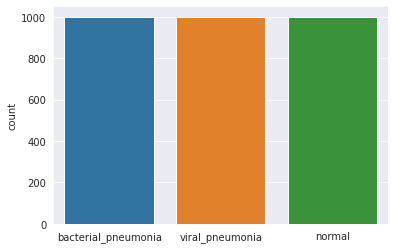

In [ ]:
X_train_usamp, y_train_usamp = undersampling(X_train.copy(), y_train.copy(), 1000, 1)
visualization_balance(y_train_usamp, 1)

del(X_train_usamp)
del(y_train_usamp)

### Affine Transformation
이동, 확대, 회전 등의 변형을 가하는 기법

In [ ]:
from tensorflow.keras import layers

affine_transformation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomTranslation(0.05, 0.05, fill_mode='constant'),
  layers.experimental.preprocessing.RandomZoom((-0.2,-0.1),(-0.2,-0.1), fill_mode='constant'),
  layers.experimental.preprocessing.RandomRotation((-0.02, 0.02), fill_mode='constant'),
])

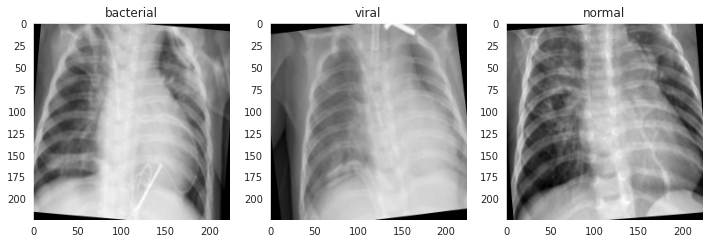

In [ ]:
X_train_affine = affine_transformation(np.reshape(X_train.copy(),(-1,img_size,img_size,1)))
plot_one_column(X_train_affine, y_train)
del(X_train_affine)

### Elastic Distortion
다양한 방향으로 생성된 displacement vector를 기반으로 이미지를 왜곡하는 기법

In [ ]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

# 출처: https://www.kaggle.com/raghakot/easier-keras-imagedatagenerator
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

In [ ]:
def my_elastic_transform(X_train):
    X_train_elas = np.zeros(X_train.shape)
    for i in range(X_train.shape[0]):
      sigma = np.random.uniform(img_size * 0.11, img_size * 0.18)
      X_train_elas[i] = elastic_transform(X_train[i].reshape(img_size, img_size).copy(),img_size, sigma)
    
    return X_train_elas

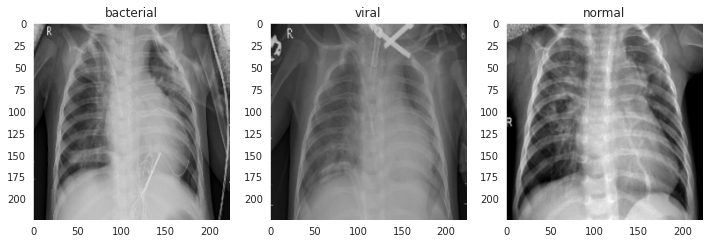

In [ ]:
X_train_elas = my_elastic_transform(X_train)
plot_one_column(X_train_elas, y_train)
del(X_train_elas)

### Needle Augmentation
원본 이미지에 무작위로 바늘 이미지를 합성

In [ ]:
# import os
# import random
# import numpy as np
# import pandas as pd
# import cv2
# import matplotlib.pyplot as plt

# import torch
# import torchvision
# from torchvision import transforms
# import tensorflow as tf
# import albumentations as A
# def NeedleAugmentation(image, n_needles=2, dark_needles=False, p=0.5, needle_folder='/content/drive/MyDrive/AIAS/dataset/needle_augmentation'):
#     aug_prob = random.random()

#     if aug_prob < p:
#         height, width, _ = image.shape  # target image width and height
#         needle_images = [im for im in os.listdir(needle_folder) if 'png' in im]

#         for _ in range(1, n_needles):
#             needle = cv2.cvtColor(cv2.imread(os.path.join(needle_folder, random.choice(needle_images))), cv2.COLOR_BGR2RGB)
#             needle = cv2.resize(needle, (134,75),needle) # 224,126
#             needle = cv2.flip(needle, random.choice([-1, 0, 1]))
#             needle = cv2.rotate(needle, random.choice([0, 1, 2]))

#             h_height, h_width, _ = needle.shape  # needle image width and height
#             roi_ho = random.randint(0, abs(image.shape[0] - needle.shape[0]))
#             roi_wo = random.randint(0, abs(image.shape[1] - needle.shape[1]))
#             roi = image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]
            
#             # Creating a mask and inverse mask 
#             img2gray = cv2.cvtColor(needle, cv2.COLOR_BGR2GRAY)
#             ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
#             mask_inv = cv2.bitwise_not(mask)

#             # Now black-out the area of needle in ROI
#             img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

#             # Take only region of insect from insect image.
#             if dark_needles:
#                 img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
#                 needle_fg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
#             else:
#                 needle_fg = cv2.bitwise_and(needle, needle, mask=mask)
            
#             # Put needle in ROI and modify the target image
#             img_bg = np.expand_dims(img_bg, axis=2)
#             img_bg = np.concatenate([img_bg,img_bg,img_bg], axis=2)
#             print('img_bg:', img_bg.shape)
#             print('needle_fg:', needle_fg.shape)
#             dst = cv2.add(img_bg, needle_fg, dtype=cv2.CV_8U)
#             print('dst:',dst.shape)

#             # dst = dst[:, :, np.newaxis]
#             # print('dst:',dst.shape)
#             print('image:',image.shape)
#             image = np.expand_dims(image, axis=2)
#             image = np.concatenate([image,image,image], axis=2)
            
#             print('image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]', image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width].shape)
#             print('np.expand_dims(dst, axis=2)', np.expand_dims(dst, axis=2).shape)
#             image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = np.expand_dims(dst, axis=3)
#             print('dst:',dst.shape)
#             print('image:',image.shape)

#             image = np.reshape(image[:,:,0], (img_size,img_size))
#             plt.imshow(image,cmap='gray')
            
#     return image

In [ ]:
# def my_NeedleAugmentation(X_train, n_needles, dark_needles, p):
#     X_train_needle = np.zeros(X_train.shape)
#     for i in range(X_train.shape[0]):
#       X_train_needle[i] = np.reshape(NeedleAugmentation(np.reshape(X_train[i].copy(), (img_size,img_size,1)), n_needles=int(n_needles), dark_needles=dark_needles, p=p), (-1,img_size,img_size))
    
#     return X_train_needle

In [ ]:
# X_tmp = np.reshape(X_train[0].copy(), (img_size,img_size,1))
# print(X_tmp.shape)
# X_train_needle = NeedleAugmentation(X_tmp, n_needles=2, dark_needles=False, p=1)

# print(X_train_needle.shape)
# # plt.imshow(np.reshape(X_train_needle,(img_size, img_size)), cmap='gray')

In [ ]:
# X_train_needle = my_NeedleAugmentation(X_train.copy(), 3, False, 1)
# plot_one_column(X_train_needle, y_train)

## 2.2. (NEW) 전처리 기법 정의

#### albumentation

In [ ]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Dryocopus_pileatus_MP2.jpg/600px-Dryocopus_pileatus_MP2.jpg -q -O example.jpg

import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import display, HTML 
from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, InvertImg, RandomGamma, ToGray, PadIfNeeded 
                           )
import albumentations as alb

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-xd3r7ft7
All libraries are successfully installed!


In [ ]:
alb_config = {
    'target_size': 224,
    'seed': 23,
    'batch_size': 8,
    'enable_preprocessing': False,

    'augm_p_corrections': 0.3,
    'augm_p_contrast': 1,
    'augm_p_gamma': 1,
    'augm_p_brightness': 1,

    'augm_p_blurs': 0.5,
    'augm_p_blur': 1,
    'augm_p_motionblur': 1,
    'augm_p_medianblur': 1,

    'augm_p_distortions': 0.3,
    'augm_p_elastic': 1,
    'augm_p_grid': 1,
    'augm_p_optical': 1,

    'augm_p_shiftscalrot': 0.3,
    'augm_shift_limit': 0.2,
    'augm_scale_limit': 0.1,
    'augm_rotate_limit': 20,
}

In [ ]:
augm = alb.Compose([
        alb.HorizontalFlip(),
        alb.OneOf([
            # alb.RandomContrast(p=config["augm_p_contrast"]),
            alb.RandomGamma(p=alb_config["augm_p_gamma"]),
            # alb.RandomBrightness(p=config["augm_p_brightness"]),
        ],
            p=alb_config["augm_p_corrections"]),
        alb.OneOf([
            alb.Blur(blur_limit=4, p=alb_config["augm_p_blur"]),
            alb.MotionBlur(blur_limit=4, p=alb_config["augm_p_motionblur"]),
            # alb.MedianBlur(blur_limit=3, p=alb_config["augm_p_medianblur"]),
        ],
            p=alb_config["augm_p_blurs"]),
        alb.OneOf([
            alb.ElasticTransform(alpha=60,
                                #  sigma=60 * 0.20,
                                 sigma=60 * 0.15,
                                 alpha_affine=60 * 0.03,
                                 p=alb_config["augm_p_elastic"]),
            alb.GridDistortion(p=alb_config["augm_p_grid"]),
            alb.OpticalDistortion(
                # distort_limit=0.2, shift_limit=0.05, p=alb_config["augm_p_optical"]),
                distort_limit=0.3, shift_limit=0.1, p=alb_config["augm_p_optical"]),
        ],
            p=alb_config["augm_p_distortions"]),
        alb.ShiftScaleRotate(shift_limit=alb_config["augm_shift_limit"],
                             scale_limit=alb_config["augm_scale_limit"],
                             rotate_limit=alb_config["augm_rotate_limit"],
                             interpolation=cv2.INTER_LINEAR,
                             border_mode=cv2.BORDER_CONSTANT,
                             p=alb_config["augm_p_shiftscalrot"]),
        # alb.Resize(alb_config["target_size"], alb_config["target_size"]),
    ])
    

In [ ]:
def get_alb_aug(X_train):
  aug_img = np.zeros(X_train.shape)
  for i in range(X_train.shape[0]):
    aug_img[i] = augm(image=X_train[i])['image']
  return aug_img

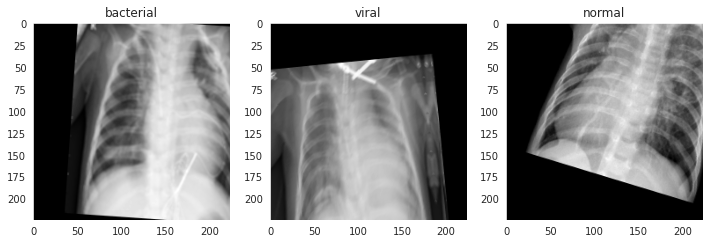

In [ ]:
X_train_aug = get_alb_aug(X_train.copy())
plot_one_column(X_train_aug,y_train)
del(X_train_aug)

### Oversampling

In [ ]:
def get_balance(y_train):
  l = []
  for i in np.argmax(y_train, axis=1): # y_train
    if(i == 0):
      l.append("bacterial_pneumonia")
    elif(i == 1):
      l.append("viral_pneumonia")
    elif (i == 2):
      l.append("normal")
    else:
      l.append("unknown")
  balance = np.zeros(3)
  balance[0] = l.count("bacterial_pneumonia")
  balance[1] = l.count("viral_pneumonia")
  balance[2] = l.count("normal")
  balance = np.array(balance, dtype='uint32')
  return balance

In [ ]:
def undersampling(X_train, y_train, target_num, shuffle):
  X_train_result = np.zeros((np.sum(target_num), img_size,img_size))
  y_train_result = np.zeros((np.sum(target_num), 3))

  if shuffle==1:
    s = np.arange(X_train.shape[0])
    np.random.shuffle(s)
    X_train = np.reshape(np.array(X_train, dtype=np.uint8)[s], (-1, img_size,img_size))
    y_train = y_train[s]
  
  idx=0
  i=0
  cnt = np.zeros(3)
  labels = np.argmax(y_train, axis=1)
  while(1):
    label = labels[i]
    i+=1
    if np.sum(cnt)==np.sum(target_num): break
    if idx==sum(target_num): break
    if i==4544: break
    if cnt[label]==target_num[label]:
      continue
    cnt[label]+=1
    X_train_result[idx]=np.reshape(X_train[i-1], (img_size,img_size))
    y_train_result[idx]=y_train[i-1]
    idx+=1

  return X_train_result, y_train_result


In [ ]:
def oversampling(X_train, y_train, max_num, shuffle):
  """
  [WARNING]
  만일 balance[k]<max_num인 경우 원치 않는 동작을 수행함
  """
  balance = get_balance(y_train)
  target_num = np.array([max_num-balance[0], max_num-balance[1], max_num-balance[2]],dtype='uint32')
  # print('balance num: ', balance)
  # print('max num: ', max_num)
  # print('target num: ', target_num)
  # print()

  X_train_u, y_train_u = undersampling(X_train.copy(), y_train.copy(), target_num, shuffle)

  balance = get_balance(y_train_u)
  # print('--- after undersampling ---')
  # print('balance num: ', balance)
  # print()

  X_train_result = np.zeros((max_num,img_size,img_size))
  y_train_result = np.zeros((max_num,3))
  X_train_result = np.concatenate([X_train, X_train_u])
  y_train_result = np.concatenate([y_train, y_train_u])

  # balance =  np.zeros(3)
  # get_balance(y_train_result, balance)
  # print('--- after oversampling ---')
  # print('balance num: ', balance)
  # print('y :', y_train_result)
  # print()

  # del(X_train_u)
  # del(y_train_u)

  return X_train_result, y_train_result


bacterial_pneumonia / viral_pneumonia / normal / unknown
2181  /  2181  /  2181  /  0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


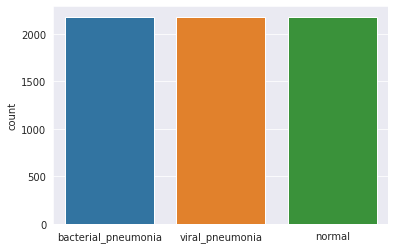

In [ ]:
X_train_osamp, y_train_osamp = oversampling(X_train, y_train, 2181, 0)
visualization_balance(y_train_osamp,1)
del(X_train_osamp)
del(y_train_osamp)

# 3. Train

## 3.1. Settings
학습 결과를 기록하기 위한 환경 설정

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 

In [ ]:
early_stop=EarlyStopping(monitor="val_loss",
                         min_delta = .001,
                         patience=6,
                         mode="auto",
                         verbose=1,
                         restore_best_weights = True
                         )
Learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.5,
                                          patience=5, 
                                          verbose=1, 
                                          min_delta = 0.01
                                          )

chkpt = ModelCheckpoint(filepath='/content/drive/MyDrive/AIAS/checkpoint/{epoch:02d}-{val_accuracy:.5f}.h5',
                        save_weights_only=True, 
                        save_best_only = True,
                        verbose=1, 
                        mode='min', 
                        monitor='val_loss'
                        )

## 3.2. Define a Model


### 3.2.3 dataset 증강 실험 및 학습 영역에 관한 실험 모델
ResNet50을 base model로 사용
* `㉠ Edit Here to change the freeze range (transfer learning)` 부분을 통해 freeze 범위를 설정할 수 있음


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

with tf.device('/device:GPU:0'): #GPU 사용하려면 돌릴 모델을 이 안쪽으로 넣어주면 된다고 함
  def build_model():
      img_input = tf.keras.Input(shape=(img_size, img_size,1), name='ImageInput')
      img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])  # 따라서 graysclae(1 channel)에서 3 channel로 증가시켜줌.  

      # < Create the Base Pre-trained Model >
      base_model = ResNet50( weights='imagenet', include_top=False, input_tensor=img_conc )
      

      # < Define the freeze range >
      # ㉠ Edit Here to change the freeze range (transfer learning)
      # ex) 144 ->114
      for layer in base_model.layers[:144]: # trainable parameters : 15,541,891 
          layer.trainable = False  
      # Check
      for i, layer in enumerate(base_model.layers):
        print(i, layer.name, "-", layer.trainable)


      # < Add User-defined Layers >
      # add a global spatial average pooling layer
      x = base_model.output
      x = GlobalAveragePooling2D()(x)
      
      # add fully-connected layers
      x = BatchNormalization(name='batchNorm1')(x)
      x = Dense(256, activation='relu', name='fc1', kernel_regularizer=keras.regularizers.l2(0.001))(x)
      x = Dropout(0.5, name='dropout1')(x) #optional
      
      x = BatchNormalization(name='batchNorm2')(x)
      x = Dense(128, activation='relu', name='fc2',kernel_regularizer=keras.regularizers.l2(0.001))(x) 
      x = Dropout(0.5, name='dropout2')(x) #optional

      # add a logistic layer
      predictions = Dense(3, activation='softmax', name='fc3')(x) 


      # < Return the Final Model >
      model = Model(inputs=img_input, outputs=predictions)
      return model

### 3.2.2 최종 테스트 모델

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

with tf.device('/device:GPU:0'): #GPU 사용하려면 돌릴 모델을 이 안쪽으로 넣어주면 된다고 함
  def build_model():
      img_input = tf.keras.Input(shape=(img_size, img_size,1), name='ImageInput')
      img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])  # 따라서 graysclae(1 channel)에서 3 channel로 증가시켜줌.  

      # create the base pre-trained model
      base_model = ResNet50( weights='imagenet', include_top=False, input_tensor=img_conc )
      for layer in base_model.layers[:144]: #trainable parameters : 15,541,891 
          layer.trainable = False  

      #check
      for i, layer in enumerate(base_model.layers):
        print(i, layer.name, "-", layer.trainable)

      # add a global spatial average pooling layer
      x = base_model.output
      x = GlobalAveragePooling2D()(x)
      
      # let's add a fully-connected 
      x = BatchNormalization(name='batchNorm1')(x)
      x = Dense(128, activation='relu', name='fc1', kernel_regularizer=keras.regularizers.l2(0.001))(x)
      x = Dropout(0.5, name='dropout1')(x) #optional
      
      x = BatchNormalization(name='batchNorm2')(x)
      x = Dense(64, activation='relu', name='fc2',kernel_regularizer=keras.regularizers.l2(0.001))(x) 
      x = Dropout(0.5, name='dropout2')(x) #optional

      x = BatchNormalization(name='batchNorm3')(x)
      x = Dense(64, activation='relu', name='fc3',kernel_regularizer=keras.regularizers.l2(0.001))(x) 
      x = Dropout(0.5, name='dropout3')(x) #optional

      # and a logistic layer
      predictions = Dense(3, activation='softmax', name='fc4')(x) 

      # this is the model we will train
      model = Model(inputs=img_input, outputs=predictions)
      return model

## 3.3. Run

### 3.3.1. With Cross-validation

Cross-validation을 수행하기 위해 다음과 같이 X_train과 X_val 변수를 합쳐줌

In [ ]:
X = np.concatenate([X_train, X_val])
Y = np.concatenate([y_train, y_val])
print('X.shape:',X.shape)
print('Y.shape:',Y.shape)

X.shape: (5111, 224, 224)
Y.shape: (5111, 3)


In [ ]:
from sklearn.model_selection import KFold

skf = KFold(n_splits=9, shuffle=True)
accuracy = []
test_loss_list=[]
test_score_list = []

for train, validation in skf.split(X, Y):

  ## <Settings>
  run = wandb.init(project='Final_AIAS',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 50,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "RenNet-50",
                     "dataset": "original+augm*3((balanced))"
                 })
  config = wandb.config  # We'll use this to configure our experiment
  callbacks=[Learning_rate_reduction, chkpt, WandbCallback()] #콜백함수에 chkpt추가 (early_stop)
  tf.keras.backend.clear_session()
  
  ## <Define the model>
  model = build_model()
  optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
  model.compile(optimizer=optimizer,
                loss = config.loss_function,
                metrics = ['accuracy']
                )

  ## <Training Dataset>
  # Original : X
  print('>> Original')
  X_model_train = X[train]
  y_model_train = Y[train]
  print('      X_model_train:',X_model_train.shape)
  print('      y_model_train:',y_model_train.shape)

  # Oversampling : X + alpha
  print('>> Oversampling')
  balance = get_balance(y_model_train)
  max_num = np.max(balance)
  
  X_model_train_oversampled = np.zeros((max_num*3,img_size,img_size))
  y_model_train_oversampled = np.zeros((max_num*3,3))
  X_model_train_oversampled, y_model_train_oversampled = oversampling(X_model_train, y_model_train, max_num, 0)
  print('after oversampling')
  print('   X_model_train_oversampled',X_model_train_oversampled.shape)
  print('   y_model_train_oversampled',y_model_train_oversampled.shape)
  print()

  # Augmentation : X' + alpha'
  print('>> Augmentation1')
  X_aug_train1 = np.stack(get_alb_aug(X_model_train_oversampled)).reshape(-1, img_size, img_size).astype('float32')
  X_aug_train2 = np.stack(get_alb_aug(X_model_train_oversampled)).reshape(-1, img_size, img_size).astype('float32')
  print('      X_aug_train1:',X_aug_train1.shape)
  print('      X_aug_train2:',X_aug_train2.shape)

  X_model_train = np.concatenate([X_model_train, X_aug_train1, X_aug_train2]) # X_aug_train3, X_aug_train4, X_model_train_u])
  del(X_aug_train1)
  del(X_aug_train2)
  y_model_train = np.concatenate([y_model_train, y_model_train_oversampled, y_model_train_oversampled]) #, y_model_train_oversampled, y_model_train_oversampled, y_model_train_u])
  print('      X_model_train:',X_model_train.shape)
  print('      y_model_train:',y_model_train.shape)

  print('>> Augmentation2')
  X_aug_train3 = np.stack(get_alb_aug(X_model_train_oversampled)).reshape(-1, img_size, img_size).astype('float32')
  print('      X_aug_train3:',X_aug_train3.shape)
  del(X_model_train_oversampled)

  X_model_train = np.concatenate([X_model_train, X_aug_train3])#, X_aug_train4]) # X_aug_train3, X_aug_train4, X_model_train_u])
  del(X_aug_train3)
  y_model_train = np.concatenate([y_model_train, y_model_train_oversampled]) #, y_model_train_oversampled]) #, y_model_train_oversampled, y_model_train_oversampled, y_model_train_u])
  del(y_model_train_oversampled)
  print('      X_model_train:',X_model_train.shape)
  print('      y_model_train:',y_model_train.shape)

  # Undersampling : alpha"
  print('>> Undersampling')
  balance = get_balance(y_model_train)
  max_num = np.max(balance)
  target_num = np.array([max_num-balance[0], max_num-balance[1], max_num-balance[2]],dtype='uint32')
  print('      max_num:',max_num)
  print('      target_num:',target_num)
  
  
  X_model_train_u =  np.zeros((np.sum(target_num),img_size,img_size))
  print('      X_model_train_u:',X_model_train_u.shape)
  y_model_train_u =  np.zeros((np.sum(target_num),3))
  X_model_train_u, y_model_train_u = undersampling(X_model_train.copy(), y_model_train.copy(), target_num, 0)
  print('      X_model_train_u:',X_model_train_u.shape)
  print('      y_model_train_u:',y_model_train_u.shape)

  # Concatenate : X + (X'+alpha')*4 + alph"
  print('>> final Concatenate ')
  X_model_train = np.concatenate([X_model_train, X_model_train_u])
  del(X_model_train_u)
  y_model_train = np.concatenate([y_model_train, y_model_train_u])
  del(y_model_train_u)
  print('      X_model_train:',X_model_train.shape)
  print('      y_model_train:',y_model_train.shape)

  # Suffling
  # print('>> Shuffling')
  # s = np.arange(X_model_train.shape[0])
  # np.random.shuffle(s)
  # X_model_train = X_model_train[s]
  # y_model_train = y_model_train[s]
  # print('      X_model_train:',X_model_train.shape)
  # print('      y_model_train:',y_model_train.shape)

  ## <Validation Dataset>
  X_model_val = X[validation]
  y_model_val = Y[validation]

  print('=== what I want ===')
  print('data size: ', X_model_train.shape[0])
  print('batch_size: ',config.batch_size)
  print('nb_epochs: ',config.epochs)
  print('nb_train_steps: ', X_model_train.shape[0]//config.batch_size)
  print()


  ## <Run>
  with tf.device('/device:GPU:0'): 
    history = model.fit(X_model_train, y_model_train,
                        epochs=config.epochs,
                        # steps_per_epoch = nb_train_steps,
                        batch_size = config.batch_size,
                        validation_data = (X_model_val, y_model_val),
                        validation_steps = 5,
                        callbacks = callbacks)
  
  run.join() #send end signal to wandb

wandb: Currently logged in as: hong-dasol (use `wandb login --relogin` to force relogin)


0 ImageInput - False
1 concatenate - False
2 conv1_pad - False
3 conv1_conv - False
4 conv1_bn - False
5 conv1_relu - False
6 pool1_pad - False
7 pool1_pool - False
8 conv2_block1_1_conv - False
9 conv2_block1_1_bn - False
10 conv2_block1_1_relu - False
11 conv2_block1_2_conv - False
12 conv2_block1_2_bn - False
13 conv2_block1_2_relu - False
14 conv2_block1_0_conv - False
15 conv2_block1_3_conv - False
16 conv2_block1_0_bn - False
17 conv2_block1_3_bn - False
18 conv2_block1_add - False
19 conv2_block1_out - False
20 conv2_block2_1_conv - False
21 conv2_block2_1_bn - False
22 conv2_block2_1_relu - False
23 conv2_block2_2_conv - False
24 conv2_block2_2_bn - False
25 conv2_block2_2_relu - False
26 conv2_block2_3_conv - False
27 conv2_block2_3_bn - False
28 conv2_block2_add - False
29 conv2_block2_out - False
30 conv2_block3_1_conv - False
31 conv2_block3_1_bn - False
32 conv2_block3_1_relu - False
33 conv2_block3_2_conv - False
34 conv2_block3_2_bn - False
35 conv2_block3_2_relu - False

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
818/818 [==============================] - 57s 69ms/step - loss: 0.9853 - accuracy: 0.6798 - val_loss: 1.4064 - val_accuracy: 0.1875

Epoch 00002: val_loss did not improve from 1.38107
Epoch 3/50
818/818 [==============================] - 57s 69ms/step - loss: 0.8550 - accuracy: 0.7099 - val_loss: 20.2034 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 1.38107
Epoch 4/50
818/818 [==============================] - 57s 69ms/step - loss: 0.7736 - accuracy: 0.7226 - val_loss: 1.5227 - val_accuracy: 0.3562

Epoch 00004: val_loss did not improve from 1.38107
Epoch 5/50
818/818 [==============================] - 57s 69ms/step - loss: 0.7152 - accuracy: 0.7355 - val_loss: 1.2933 - val_accuracy: 0.5562

Epoch 00005: val_loss improved from 1.38107 to 1.29331, saving model to /content/drive/MyDrive/AIAS/checkpoint/05-0.55625.h5
Epoch 6/50
818/818 [==============================] - 57s 69ms/step - loss: 0.6792 - accuracy: 0.7378 - val_loss: 1.0397 - val_accuracy: 

epoch,49
loss,0.36638
accuracy,0.86604
val_loss,0.72812
val_accuracy,0.75625
lr,0.0
_runtime,2945
_timestamp,1623512026
_step,49
best_val_loss,0.35032
best_epoch,6


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████████████████
val_loss,▁▁█▁▁▁▁▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▂▁▄▅█▂▁▅▂▄▄▆▆▆▆▄▇▅▆▆▆▇▇▇▆▇▇▇▆▆▆▇▇▆▆▆▇▆▆
lr,█████▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


0 ImageInput - False
1 concatenate - False
2 conv1_pad - False
3 conv1_conv - False
4 conv1_bn - False
5 conv1_relu - False
6 pool1_pad - False
7 pool1_pool - False
8 conv2_block1_1_conv - False
9 conv2_block1_1_bn - False
10 conv2_block1_1_relu - False
11 conv2_block1_2_conv - False
12 conv2_block1_2_bn - False
13 conv2_block1_2_relu - False
14 conv2_block1_0_conv - False
15 conv2_block1_3_conv - False
16 conv2_block1_0_bn - False
17 conv2_block1_3_bn - False
18 conv2_block1_add - False
19 conv2_block1_out - False
20 conv2_block2_1_conv - False
21 conv2_block2_1_bn - False
22 conv2_block2_1_relu - False
23 conv2_block2_2_conv - False
24 conv2_block2_2_bn - False
25 conv2_block2_2_relu - False
26 conv2_block2_3_conv - False
27 conv2_block2_3_bn - False
28 conv2_block2_add - False
29 conv2_block2_out - False
30 conv2_block3_1_conv - False
31 conv2_block3_1_bn - False
32 conv2_block3_1_relu - False
33 conv2_block3_2_conv - False
34 conv2_block3_2_bn - False
35 conv2_block3_2_relu - False

epoch,49
loss,0.31252
accuracy,0.87707
val_loss,0.71026
val_accuracy,0.70625
lr,0.0
_runtime,2944
_timestamp,1623514978
_step,49
best_val_loss,0.07616
best_epoch,15


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████
val_loss,▁▁▄▂▆█▁▃▁▃▃▁▁▂▁▃▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▇▁▂▁▁▅▂█▁▁▇█▇█▁▆▇▃▆▇▇▇▄▇▇▅▆▆▆▆▆▆▆▆▆▆▆▆▆
lr,████████▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


0 ImageInput - False
1 concatenate - False
2 conv1_pad - False
3 conv1_conv - False
4 conv1_bn - False
5 conv1_relu - False
6 pool1_pad - False
7 pool1_pool - False
8 conv2_block1_1_conv - False
9 conv2_block1_1_bn - False
10 conv2_block1_1_relu - False
11 conv2_block1_2_conv - False
12 conv2_block1_2_bn - False
13 conv2_block1_2_relu - False
14 conv2_block1_0_conv - False
15 conv2_block1_3_conv - False
16 conv2_block1_0_bn - False
17 conv2_block1_3_bn - False
18 conv2_block1_add - False
19 conv2_block1_out - False
20 conv2_block2_1_conv - False
21 conv2_block2_1_bn - False
22 conv2_block2_1_relu - False
23 conv2_block2_2_conv - False
24 conv2_block2_2_bn - False
25 conv2_block2_2_relu - False
26 conv2_block2_3_conv - False
27 conv2_block2_3_bn - False
28 conv2_block2_add - False
29 conv2_block2_out - False
30 conv2_block3_1_conv - False
31 conv2_block3_1_bn - False
32 conv2_block3_1_relu - False
33 conv2_block3_2_conv - False
34 conv2_block3_2_bn - False
35 conv2_block3_2_relu - False

epoch,49
loss,0.36864
accuracy,0.85383
val_loss,0.58015
val_accuracy,0.78125
lr,0.0
_runtime,2912
_timestamp,1623517897
_step,49
best_val_loss,0.29823
best_epoch,28


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
val_loss,▁█▄▂▁▂▃▂▁▂▃▁▂▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▁▃▁█▁▁▂▇▄▂▅▁▃▂▅▅▃▇▅▄▇▄▇▇▆▆▇▄▇▇▆▆▇▅▇▇▇▇▇
lr,█████████▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


0 ImageInput - False
1 concatenate - False
2 conv1_pad - False
3 conv1_conv - False
4 conv1_bn - False
5 conv1_relu - False
6 pool1_pad - False
7 pool1_pool - False
8 conv2_block1_1_conv - False
9 conv2_block1_1_bn - False
10 conv2_block1_1_relu - False
11 conv2_block1_2_conv - False
12 conv2_block1_2_bn - False
13 conv2_block1_2_relu - False
14 conv2_block1_0_conv - False
15 conv2_block1_3_conv - False
16 conv2_block1_0_bn - False
17 conv2_block1_3_bn - False
18 conv2_block1_add - False
19 conv2_block1_out - False
20 conv2_block2_1_conv - False
21 conv2_block2_1_bn - False
22 conv2_block2_1_relu - False
23 conv2_block2_2_conv - False
24 conv2_block2_2_bn - False
25 conv2_block2_2_relu - False
26 conv2_block2_3_conv - False
27 conv2_block2_3_bn - False
28 conv2_block2_add - False
29 conv2_block2_out - False
30 conv2_block3_1_conv - False
31 conv2_block3_1_bn - False
32 conv2_block3_1_relu - False
33 conv2_block3_2_conv - False
34 conv2_block3_2_bn - False
35 conv2_block3_2_relu - False

KeyboardInterrupt: ignored

### 3.3.2. Without Cross-validation

In [ ]:
del(X)
del(Y)

## <Settings>
run = wandb.init(project='Final_AIAS',
                config={  # and include hyperparameters and metadata
                    "learning_rate": 0.0001,
                    "epochs": 50,
                    "batch_size": 32,
                    "loss_function": "categorical_crossentropy",
                    "architecture": "RenNet-50",
                    "dataset": "original+augm*3((balanced))"
                })
config = wandb.config  # We'll use this to configure our experiment
callbacks=[Learning_rate_reduction, chkpt, WandbCallback()] #콜백함수에 chkpt추가 (early_stop)
tf.keras.backend.clear_session()

## <Define the model>
model = build_model()
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer=optimizer,
              loss = config.loss_function,
              metrics = ['accuracy']
              )

## <Training Dataset>
# Original : X
print('>> Original')
X_model_train = X_train
y_model_train = y_train
print('      X_model_train:',X_model_train.shape)
print('      y_model_train:',y_model_train.shape)

# Oversampling : X + alpha
print('>> Oversampling')
balance = get_balance(y_model_train)
max_num = np.max(balance)

X_model_train_oversampled = np.zeros((max_num*3,img_size,img_size))
y_model_train_oversampled = np.zeros((max_num*3,3))
X_model_train_oversampled, y_model_train_oversampled = oversampling(X_model_train, y_model_train, max_num, 0)
print('after oversampling')
print('   X_model_train_oversampled',X_model_train_oversampled.shape)
print('   y_model_train_oversampled',y_model_train_oversampled.shape)
print()

# Augmentation : X' + alpha'
print('>> Augmentation1')
X_aug_train1 = np.stack(get_alb_aug(X_model_train_oversampled)).reshape(-1, img_size, img_size).astype('float32')
X_aug_train2 = np.stack(get_alb_aug(X_model_train_oversampled)).reshape(-1, img_size, img_size).astype('float32')
print('      X_aug_train1:',X_aug_train1.shape)
print('      X_aug_train2:',X_aug_train2.shape)

X_model_train = np.concatenate([X_model_train, X_aug_train1, X_aug_train2]) # X_aug_train3, X_aug_train4, X_model_train_u])
del(X_aug_train1)
del(X_aug_train2)
y_model_train = np.concatenate([y_model_train, y_model_train_oversampled, y_model_train_oversampled]) #, y_model_train_oversampled, y_model_train_oversampled, y_model_train_u])
print('      X_model_train:',X_model_train.shape)
print('      y_model_train:',y_model_train.shape)

print('>> Augmentation2')
X_aug_train3 = np.stack(get_alb_aug(X_model_train_oversampled)).reshape(-1, img_size, img_size).astype('float32')
print('      X_aug_train3:',X_aug_train3.shape)
del(X_model_train_oversampled)

X_model_train = np.concatenate([X_model_train, X_aug_train3])#, X_aug_train4]) # X_aug_train3, X_aug_train4, X_model_train_u])
del(X_aug_train3)
y_model_train = np.concatenate([y_model_train, y_model_train_oversampled]) #, y_model_train_oversampled]) #, y_model_train_oversampled, y_model_train_oversampled, y_model_train_u])
del(y_model_train_oversampled)
print('      X_model_train:',X_model_train.shape)
print('      y_model_train:',y_model_train.shape)

# Undersampling : alpha"
print('>> Undersampling')
balance = get_balance(y_model_train)
max_num = np.max(balance)
target_num = np.array([max_num-balance[0], max_num-balance[1], max_num-balance[2]],dtype='uint32')
print('      max_num:',max_num)
print('      target_num:',target_num)


X_model_train_u =  np.zeros((np.sum(target_num),img_size,img_size))
print('      X_model_train_u:',X_model_train_u.shape)
y_model_train_u =  np.zeros((np.sum(target_num),3))
X_model_train_u, y_model_train_u = undersampling(X_model_train.copy(), y_model_train.copy(), target_num, 0)
print('      X_model_train_u:',X_model_train_u.shape)
print('      y_model_train_u:',y_model_train_u.shape)

# Concatenate : X + (X'+alpha')*4 + alph"
print('>> final Concatenate ')
X_model_train = np.concatenate([X_model_train, X_model_train_u])
del(X_model_train_u)
y_model_train = np.concatenate([y_model_train, y_model_train_u])
del(y_model_train_u)
print('      X_model_train:',X_model_train.shape)
print('      y_model_train:',y_model_train.shape)

# Suffling
# print('>> Shuffling')
# s = np.arange(X_model_train.shape[0])
# np.random.shuffle(s)
# X_model_train = X_model_train[s]
# y_model_train = y_model_train[s]
# print('      X_model_train:',X_model_train.shape)
# print('      y_model_train:',y_model_train.shape)

## <Validation Dataset>
X_model_val = X_val
y_model_val = y_val

print('=== what I want ===')
print('data size: ', X_model_train.shape[0])
print('batch_size: ',config.batch_size)
print('nb_epochs: ',config.epochs)
print('nb_train_steps: ', X_model_train.shape[0]//config.batch_size)
print()


## <Run>
with tf.device('/device:GPU:0'): 
  history = model.fit(X_model_train, y_model_train,
                      epochs=config.epochs,
                      # steps_per_epoch = nb_train_steps,
                      batch_size = config.batch_size,
                      validation_data = (X_model_val, y_model_val),
                      validation_steps = 5,
                      callbacks = callbacks)

run.join() #send end signal to wandb

# 4. Validation

## 4.1. Accuracy per Epochs

In [ ]:
epochs = [i for i in range(50)] # Early Stopping 주의
# print(np.shape(acc),np.shape(acc))

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

## 4.2. Heatmap & Precision-Recall

In [ ]:
# Load the model weights
# model.load_weights("/content/drive/MyDrive/AIAS2/case1/48-0.87500.h5") #best weights
y_pred = model.predict(X_val)

print(y_val.shape, y_pred.shape)
cm = confusion_matrix(np.argmax(y_val, axis=1),
                      np.argmax(y_pred, axis=1))
cm = pd.DataFrame(cm , index = ['0','1','2,'] , columns = ['0','1','2'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
bb, bv, bn, vb, vv, vn, nb, nv, nn = cm.values.ravel() #실제-예측 순서

precision_b = bb/(bb+vb+nb) 
recall_b = bb/(bn+bv+bb)

precision_v = vv/(bv+vv+nv) 
recall_v = vv/(vn+vv+vb)

precision_n = nn/(bn+vn+nn) 
recall_n = nn/(nn+nv+nb)

print("Recall_b of the model is {:.2f}".format(recall_b))
print("Precision_b of the model is {:.2f}\n".format(precision_b))

print("Recall_v of the model is {:.2f}".format(recall_v))
print("Precision_v of the model is {:.2f}".format(precision_v))

print("Recall_n of the model is {:.2f}".format(recall_n))
print("Precision_n of the model is {:.2f}\n".format(precision_n))

# 5. Test

## 5.1. Heatmap & Precision-Recall

In [ ]:
# Load the model weights
# model.load_weights("/content/drive/MyDrive/AIAS2/case1/48-0.87500.h5") #best weight

# Evaluation on test dataset
test_loss, test_score = model.evaluate(X_test, y_test, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

In [ ]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1),
                      np.argmax(y_pred, axis=1))
cm = pd.DataFrame(cm , index = ['0','1','2,'] , columns = ['0','1','2'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
bb, bv, bn, vb, vv, vn, nb, nv, nn = cm.values.ravel() #실제-예측 순서

precision_b = bb/(bb+vb+nb) 
recall_b = bb/(bn+bv+bb)

precision_v = vv/(bv+vv+nv) 
recall_v = vv/(vn+vv+vb)

precision_n = nn/(bn+vn+nn) 
recall_n = nn/(nn+nv+nb)

print("Recall_b of the model is {:.2f}".format(recall_b))
print("Precision_b of the model is {:.2f}\n".format(precision_b))

print("Recall_v of the model is {:.2f}".format(recall_v))
print("Precision_v of the model is {:.2f}".format(precision_v))

print("Recall_n of the model is {:.2f}".format(recall_n))
print("Precision_n of the model is {:.2f}\n".format(precision_n))

## 5.2. Convolutional Activation Map

In [ ]:
import tensorflow.keras.backend as K
from google.colab.patches import cv2_imshow

from tensorflow.keras.preprocessing import image

num=-10

x = np.copy(X_test[num])
x = np.concatenate((x,x,x), axis=2)
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x = x[:,:,:,0]
x = np.expand_dims(x, axis=3)

with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv5_block3_add') # [0][0] conv1_pad conv5_block3_add
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  print('x:', x.shape)
  model_out, last_conv_layer = iterate(x)
  print('model_out:', model_out.shape)
  print('last_conv_layer:', last_conv_layer.shape)
  class_out = model_out[:, np.argmax(model_out)] # model_out[0]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
tmp = tf.multiply(pooled_grads, last_conv_layer)
#print('tmp:',tmp.shape)
heatmap = tf.reduce_mean(tmp, axis=-1)
#print('heatmap:', heatmap.shape)
print()

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
#print('heatmap:', heatmap.shape)
heatmap = heatmap.reshape((7, 7))

heatmap = cv2.resize(heatmap, (img_size, img_size))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
heatmap = cv2.resize(heatmap, dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
#print('heatmap:', heatmap.shape)

img = np.copy(X_test[num])
INTENSITY = 0.5
img = heatmap * INTENSITY + img
cv2_imshow(img)